# Volatility Arbitrage Strategy

In [18]:
# import all necessary library
import pandas as pd 
import numpy as np 
import yfinance as yf
import matplotlib.pyplot as plt
import os

## Data Cleaning

- retrieve spx option data from Bloomberg
- retrieve spx index data from yhoo finance
- clean data
  - unnecessary rows and columns
  - option ticker breakdown
  - expiration date format
  - keep options with certain expiration date which have more than 10 implied volatility
  - calculate moneyness
  - save the term structure of options


In [19]:
# import option data csv file
# os.chdir('D:/Github/volatility_arbitrage/SPX_option_price/20230901/')
option_data = pd.read_csv('./Public/data/option_price/20230901/spx_option_0901.csv')

option_data = option_data.dropna()

# ticker breakdown for call
option_data[['Index', 'Expiry', 'strike']] = option_data['Ticker'].str.split(' ', expand=True)
option_data['Type'] = option_data['strike'].str[0]
option_data.drop(['strike'], axis=1, inplace=True)

# ticker breakdown for put
option_data[['Index.1', 'Expiry.1', 'strike']] = option_data['Ticker.1'].str.split(' ', expand=True)
option_data['Type.1'] = option_data['strike'].str[0]
option_data.drop(['strike'], axis=1, inplace=True)

# spit call and put data
call_data = option_data[option_data.columns[~option_data.columns.str.contains('.1')]]
put_data = option_data[option_data.columns[option_data.columns.str.contains('.1')]]
put_data.columns = call_data.columns
call_data = call_data[['Ticker', 'Index', 'Type', 'Expiry', 'Strike', 'Bid', 'Ask', 'Last', 'Volm', 'IVM']]
put_data = put_data[['Ticker', 'Index', 'Type', 'Expiry', 'Strike', 'Bid', 'Ask', 'Last', 'Volm', 'IVM']]

# redefine option data as call concat put, convert strike to integer, convert expiry to datetime format, sort data by expiray and strike, delete 0 volume rows 
option_data = pd.concat([call_data, put_data], axis=0)
option_data['Strike'] = option_data['Strike'].astype(int)
option_data['Expiry'] = pd.to_datetime(option_data['Expiry'], format='%m/%d/%y')
option_data['Expiry'] = option_data['Expiry'].dt.date
option_data = option_data.sort_values(by=['Type', 'Expiry', 'Index', 'Strike'])
option_data = option_data[option_data['Volm'] != 0]

In [20]:
# keep expiry with enough implied volatility data
expiry_list = option_data['Expiry'].unique()
expiry_keep = []

for expiry in expiry_list:
    # for each expiry, get the unique strike
    option_data_expiry = option_data[option_data['Expiry'] == expiry]
    option_strike = option_data_expiry['Strike'].unique()
    # if strike_keep has more than 10 unique strike, keep the expiry
    if len(option_strike) > 10:
        expiry_keep.append(expiry)

option_data = option_data[option_data['Expiry'].isin(expiry_keep)]

expiry_list = option_data['Expiry'].unique()
print(expiry_list)

[datetime.date(2023, 9, 15) datetime.date(2023, 10, 20)
 datetime.date(2023, 10, 31) datetime.date(2023, 11, 17)
 datetime.date(2023, 11, 30) datetime.date(2023, 12, 15)
 datetime.date(2024, 1, 19) datetime.date(2024, 1, 31)
 datetime.date(2024, 2, 16) datetime.date(2024, 3, 15)
 datetime.date(2024, 3, 28) datetime.date(2024, 4, 19)
 datetime.date(2024, 5, 17) datetime.date(2024, 6, 21)
 datetime.date(2024, 6, 28) datetime.date(2024, 9, 20)
 datetime.date(2024, 12, 20) datetime.date(2025, 6, 20)]


,Ticker,Index,Type,Expiry,Strike,Bid,Ask,Last,Volm,IVM,Moneyness
610,SPX 9/15/23 C4470,SPX,C,2023-09-15,4470,66.699997,67.699997,68.380005,16.0,10.665597,1.013557
611,SPX 9/15/23 C4475,SPX,C,2023-09-15,4475,62.900009,63.900009,61.449997,18.0,10.570473,1.012425
612,SPX 9/15/23 C4480,SPX,C,2023-09-15,4480,59.100006,60.199997,53.169998,6.0,10.464067,1.011295
614,SPX 9/15/23 C4490,SPX,C,2023-09-15,4490,52.000000,53.000000,52.119995,11.0,10.279760,1.009042
615,SPX 9/15/23 C4495,SPX,C,2023-09-15,4495,48.599991,49.599991,48.669998,6.0,10.197698,1.007920


Empty DataFrame
Columns: [Ticker, Index, Type, Expiry, Strike, Bid, Ask, Last, Volm, IVM, Moneyness]
Index: []


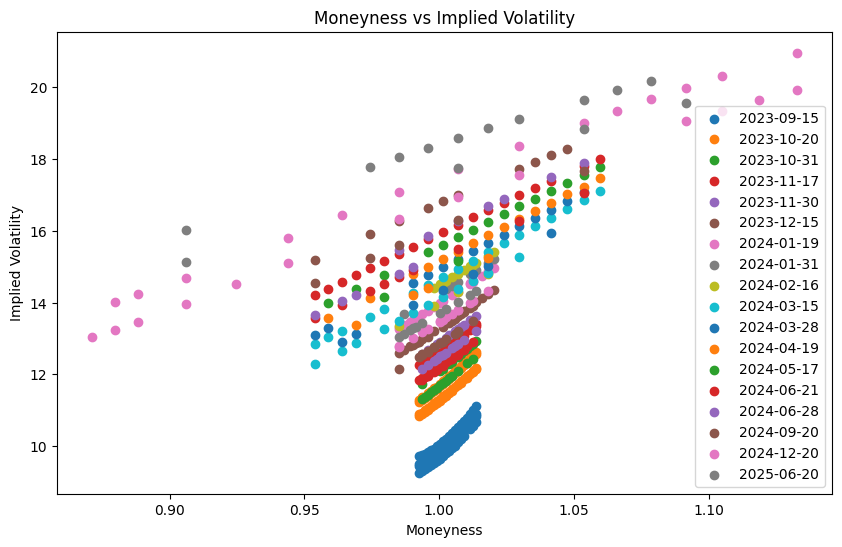

In [23]:
# from yahoo finance, get the SPX historical price
def get_spx_hist(start, end):
    spx = yf.Ticker('^GSPC')
    spx_hist = spx.history(start=start, end=end)
    spx_hist = spx_hist.reset_index()
    spx_hist = spx_hist[['Date', 'Open']]
    spx_hist['Date'] = pd.to_datetime(spx_hist['Date'], format='%Y-%m-%d')
    spx_hist['Date'] = spx_hist['Date'].dt.date
    spx_hist = spx_hist.rename(columns={'Close':'SPX'})
    spx_hist = spx_hist.set_index('Date')
    spx_hist.to_csv(f'./Public/data/index_price/spx_hist_{start}_{end}.csv')
    return spx_hist

# spx_data = get_spx_hist('2021-09-01', '2023-11-07')
spx_data = pd.read_csv('./Public/data/index_price/spx_hist_2021-09-01_2023-11-07.csv', index_col='Date')

# calcualte moneyness
spx_0901 = spx_data.loc['2023-09-01', 'Open']

option_data['Moneyness'] = spx_0901 / option_data['Strike']

display(option_data.head())
# print option_data in 2023-09-15
print(option_data[option_data['Expiry'] == '2023-09-15'])

# plot moneyness vs IVM for each expiry with different color
plt.figure(figsize=(10, 6))
for expiry in expiry_list:
    option_data_expiry = option_data[option_data['Expiry'] == expiry]
    plt.scatter(option_data_expiry['Moneyness'], option_data_expiry['IVM'], label=expiry)
plt.xlabel('Moneyness')
plt.ylabel('Implied Volatility')
plt.title('Moneyness vs Implied Volatility')
plt.legend()
plt.show()

## Fix Implied Volatility Surface

### Find BS Implied Volatility

- use put-call parity to calculate the risk-free rate and dividend yield for spx index option
- use Black-Scholes model to calculate the implied volatility for each option

### Fit BS Implied Volatility Surface

- calculate the implied volatility for each option using the implied volatility of the at-the-money option with the same expiration date
- for the same expiration date, fit the implied volatility curve against spot moneyness using function below:
  - option 1: similar to tanh function
    $$
    \sigma(x)^2 = \sigma_{atm}^2 + \delta\displaystyle\left(\frac{\tanh(\kappa x)}{\kappa}\right) + \frac{\gamma}{2}\left(\frac{\tanh(\kappa x)}{\kappa}\right)^2,\quad
    \text{where }x = \displaystyle\ln(\frac{K}{S})
    $$
  - option 2: similar to sigmoid function
- for different expiration date, for same moneyness, connect the implied volatility curve using cubic spline interpolation

### Convert BS Implied Volatility Surface to Local Volatility Surface

- use Dupire's formula to calculate the local volatility for each option
![BS vs Local](./Public/BS_vs_local_var.png)

## Trading Strategy

- if the implied volatility of an option is higher than the local volatility, then sell the option

## Backtesting

# To-do List
- after delete the rows with 0 volume, the moneyness with near expiration date is close to 0, it is hard to fit the implied volatility curve

# Reference

[SPX vs. SPXW Options: Understanding the Key Differences](https://insideoptions.io/spx-spxw-options-differences/)  
[Cubic Spline Interpolation](https://en.wikipedia.org/wiki/Spline_interpolation#Algorithm_to_find_the_interpolating_cubic_spline)